# Fitting QENS data

Previously, some quasi-elastic neutron scattering (QENS) data has been [simulated](./../3-mcstas/QENS_from_function.ipynb) and [reduced](./../4-scipp/qens-reduction.ipynb) and can now be analysed with `easyscience`. 
Before the analysis can begin, it is necessary to load the experimental data and check that it looks reasonable. 
The data can be loaded with `np.loadtxt` as the data has been stored in a simple space-separated column file.

In [1]:
import numpy as np

qens_data = np.loadtxt('../4-reduction/qens_energy_transfer_unknown_quasi_elastic_3_pulse.dat', unpack=True)

With the data read in, we can produce a quick plot. 

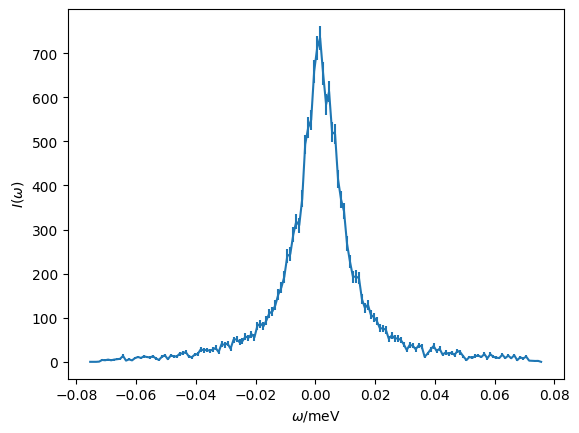

In [2]:
import matplotlib.pyplot as plt

plt.errorbar(*qens_data)
plt.xlabel('$\omega$/meV')
plt.ylabel('$I(\omega)$')
plt.show()

The QENS data covers a slightly broader range than we want to investigate.
Therefore, we will crop the data so that we are only using points between -0.06 and 0.06 meV. 

In [3]:
q, i, di = qens_data[:, np.where((qens_data[0] > -0.06) & (qens_data[0] < 0.06))[0]]

We now want to consider the mathematical model to be used in the analysis. 
QENS data is typically analysed by fitting a Lorentzian function to the data, which has the functional form

$$
I(\omega) = \frac{A\tau}{\pi\big[(\omega - \omega_0) ^ 2 + \tau ^ 2\big]},
$$ (lorentzian)

where $A$ is a scale factor, $\tau$ is the half-width at half-maximum, and $\omega_0$ is the centre offset. 

```{admonition} Task
:class: important
Write a function that implements Eqn. {eq}`lorentzian`, called `lorentzian`. 
```

<i class="fa-solid fa-bell"></i> **Click below to show code solution**

In [4]:
def lorentzian(omega: np.ndarray) -> np.ndarray:
    """
    A Lorentzian function.
    
    :omega: the energy transfer values to calculate over.

    :return: intensity values.
    """
    return A.value / np.pi * tau.value / ((omega - omega_0.value) ** 2 + tau.value ** 2)

The instrument has a finite resolution, and to take this into account, the Lorentzian function must be convolved with this resolution. In our case, the resolution is a Gaussian distribution that is centred at zero with width, $\sigma$. 
In real experiments there are ways to measure $\sigma$, but for this project, we will simply model it. 

In [5]:
from scipy.stats import norm

def intensity(omega):
    """
    The convolution of a Gaussian and the Lorentzian.
    
    :omega: the energy transfer values to calculate over.

    :return: intensity values.
    """
    gauss = norm(0, sigma.value).pdf(omega)
    gauss /= gauss.sum()
    return np.convolve(lorentzian(omega), gauss, 'same')

This means that there are a total of four parameters in our model. 

```{admonition} Task
:class: important
Create four `Parameter` objects, for $A$, $\tau$, $\omega_0$, and $\sigma$. 
Each should have an initial value and a uniform prior distribution, based on the values given in {numref}`qens-parameters`.
```

```{list-table} Parameter values for the spherical model.
:name: qens-parameters
:header-rows: 1
:align: center

* - Parameter
  - Initial Value
  - Min
  - Max
* - $A$
  - 10
  - 1
  - 100
* - $\tau$
  - 8.0 &times; 10<sup>-3</sup>
  - 1.0 &times; 10<sup>-4</sup>
  - 1.0 &times; 10<sup>-2</sup>
* - $\omega_0$
  - 1.0 &times; 10<sup>-3</sup>
  - 0
  - 2.0 &times; 10<sup>-3</sup>
* - $\sigma$
  - 1.0 &times; 10<sup>-3</sup>
  - 1.0 &times; 10<sup>-5</sup>
  - 1.0 &times; 10<sup>-1</sup>
```

<i class="fa-solid fa-bell"></i> **Click below to show code solution**

In [6]:
from easyscience.Objects.new_variable import Parameter

A = Parameter(name='A', value=10, fixed=False, min=0.01, max=100)
tau = Parameter(name='tau', value=8e-3, fixed=False, min=1e-4, max=10e-3)
omega_0 = Parameter(name='omega_0', value=0.001, fixed=False, min=0, max=0.002)
sigma = Parameter(name='sigma', value=0.001, fixed=False, min=1e-5, max=0.1)

It is now possible to compare our model at the initial estimates to the simulated data. 

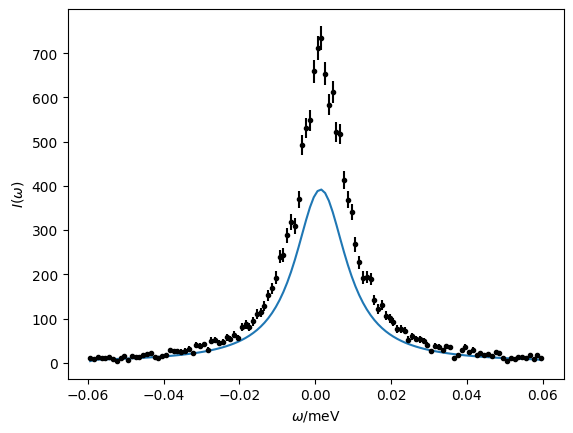

In [7]:
plt.errorbar(q, i, di, marker='.', ls='', color='k')
plt.plot(q, intensity(q), '-')
plt.xlabel('$\omega$/meV')
plt.ylabel('$I(\omega)$')
plt.show()

```{admonition} Task
:class: important
Using `easyscience` obtain maximum likelihood estimates for the four parameters of the model from comparison with the data.
```

<i class="fa-solid fa-bell"></i> **Click below to show code solution**

In [8]:
from easyscience.Objects.ObjectClasses import BaseObj
from easyscience.fitting import Fitter

params = BaseObj(name='params', A=A, tau=tau, omega_0=omega_0, sigma=sigma)
f = Fitter(params, intensity)

res = f.fit(x=q, y=i, weights=1/di)

We can then plot the model and the data together as before and print the values of the parameters along with their uncertainties. 

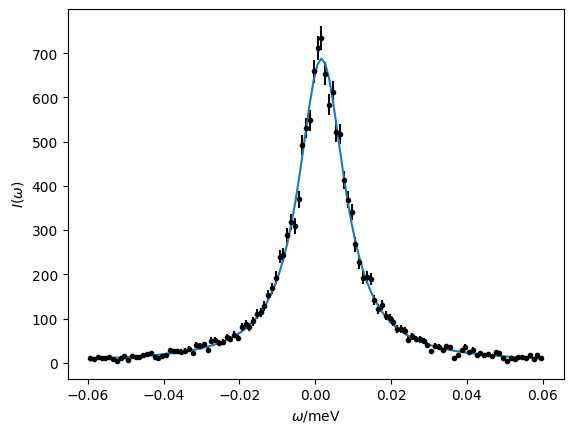

In [10]:
plt.errorbar(q, i, di, marker='.', ls='', color='k')
plt.plot(q, intensity(q), '-')
plt.xlabel('$\omega$/meV')
plt.ylabel('$I(\omega)$')
plt.show()

In [11]:
A, tau, omega_0, sigma

(<Parameter 'A': 15.5652 ± 0.1730, bounds=[0.01:100.0]>,
 <Parameter 'tau': 0.0070 ± 0.0002, bounds=[0.0001:0.01]>,
 <Parameter 'omega_0': 0.0013 ± 0.0001, bounds=[0.0:0.002]>,
 <Parameter 'sigma': 0.0013 ± 0.0006, bounds=[1e-05:0.1]>)